<a href="https://colab.research.google.com/github/rahmanidashti/CQSatisfaction/blob/main/MIMICS_Characteristics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis

## Install and Import

In [ ]:
! pip install rouge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# import
import re
import copy
import pandas as pd
from rouge import Rouge
from tqdm import tqdm
import numpy as np
from scipy import stats
from textblob import TextBlob
import collections
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

## Data Loading

In [ ]:
DATASET = "MIMICS"
# load dataset in a pandas dataframe
if DATASET == "MIMICS":
  dataset_df = pd.read_csv(f"https://raw.githubusercontent.com/microsoft/MIMICS/master/data/MIMICS-Manual.tsv", sep='\t')
elif DATASET == "MIMICS-Duo":
  dataset_df = pd.read_csv(f"https://raw.githubusercontent.com/Leila-Ta/MIMICS-Duo/main/Data/Task2-QualityLabelling.tsv", sep='\t')

In [ ]:
if DATASET == "MIMICS-Duo":
    target = 'OverallClarificationPaneQuality'
    dataset_df.loc[dataset_df[target] == 2, target] = 1
    dataset_df.loc[dataset_df[target] == 3, target] = 2
    dataset_df.loc[dataset_df[target] == 4, target] = 3
    dataset_df.loc[dataset_df[target] == 5, target] = 3

> Labels in MIMICS-Manual: 2 (Good), 1 (Fair), or 0 (Bad)

In [ ]:
dataset_df.head(1)

,query,question,option_1,option_2,option_3,option_4,option_5,question_label,options_overall_label,option_label_1,option_label_2,option_label_3,option_label_4,option_label_5
0,caesars atlantic city,Select one to refine your search,caesars atlantic city events,caesars atlantic city jobs,caesars atlantic city parking,NaN,NaN,NaN,1,2,2,2.0,NaN,NaN


## Dataset Statistics

In [ ]:
print(f"The number of samples: {dataset_df.shape}")
print(f"The number of Nan in 'question_label': {dataset_df['question_label'].isna().sum()} - ({dataset_df.shape[0] - dataset_df['question_label'].isna().sum()})")
print(f"The number of Nan in 'options_overall_label': {dataset_df['options_overall_label'].isna().sum()}") #

num_question_label = dataset_df.shape[0] - dataset_df['question_label'].isna().sum()
num_option_label = dataset_df.shape[0] - dataset_df['options_overall_label'].isna().sum()

The number of samples: (2832, 14)
The number of Nan in 'question_label': 2257 - (575)
The number of Nan in 'options_overall_label': 0


### Clarification Questions Templates

In [ ]:
cq_to_count = dict()
for cq in dataset_df.itertuples(index=True):
  if cq.question not in cq_to_count.keys():
    cq_to_count[cq.question] = 1
  else:
    cq_to_count[cq.question] += 1

In [ ]:
print(f"The numebr of unique CQ: {len(cq_to_count)}")

The numebr of unique CQ: 252


In [ ]:
# cq_to_count

## CQ Quality Analysis

In [ ]:
#
def add_template_to_dict(cq_template, cq_count, cq_label, ca_label):
    if cq_template not in template_cq_to_count.keys():
      template_cq_to_count[cq_template] = {'count': 0, 'cqBad': 0, 'cqFair': 0, 'cqGood': 0, 'caBad': 0, 'caFair': 0, 'caGood': 0}
      template_cq_to_count[cq_template]['count'] = cq_count
      if not math.isnan(cq_label):
        if cq_label == 0:
          template_cq_to_count[cq_template]['cqBad'] = 1
        elif cq_label == 1:
          template_cq_to_count[cq_template]['cqFair'] = 1
        elif cq_label == 2:
          template_cq_to_count[cq_template]['cqGood'] = 1
      #
      if not math.isnan(ca_label):
        if ca_label == 0:
          template_cq_to_count[cq_template]['caBad'] = 1
        elif ca_label == 1:
          template_cq_to_count[cq_template]['caFair'] = 1
        elif ca_label == 2:
          template_cq_to_count[cq_template]['caGood'] = 1
    else:
      template_cq_to_count[cq_template]['count'] += cq_count
      if not cq_label == None:
        if cq_label == 0:
          template_cq_to_count[cq_template]['cqBad'] += 1
        elif cq_label == 1:
          template_cq_to_count[cq_template]['cqFair'] += 1
        elif cq_label == 2:
          template_cq_to_count[cq_template]['cqGood'] += 1
      #
      if not math.isnan(ca_label):
        if ca_label == 0:
          template_cq_to_count[cq_template]['caBad'] += 1
        elif ca_label == 1:
          template_cq_to_count[cq_template]['caFair'] += 1
        elif ca_label == 2:
          template_cq_to_count[cq_template]['caGood'] += 1

In [ ]:
# Here we create a dictionary that the key is the len of non-nan options generate for each clarification question
# and the values are the number of options with respect to key and the number of lables for CQ and Overal Candidate Answers
def candidate_answers(option_1, option_2, option_3, option_4, option_5, cq_label, ca_label):
  options = [option_1, option_2, option_3, option_4, option_5]
  # the number of non-nan candidate answers (or options)
  non_nan_options = len([option for option in options if option is not np.nan])

  if non_nan_options not in answers_count_to_labels.keys():
    answers_count_to_labels[non_nan_options] = {'count': 0, 'cqBad': 0, 'cqFair': 0, 'cqGood': 0, 'caBad': 0, 'caFair': 0, 'caGood': 0}
    answers_count_to_labels[non_nan_options]['count'] = 1
    if not math.isnan(cq_label):
      if cq_label == 0:
        answers_count_to_labels[non_nan_options]['cqBad'] = 1
      elif cq_label == 1:
        answers_count_to_labels[non_nan_options]['cqFair'] = 1
      elif cq_label == 2:
        answers_count_to_labels[non_nan_options]['cqGood'] = 1
    #
    if not math.isnan(ca_label):
        if ca_label == 0:
          answers_count_to_labels[non_nan_options]['caBad'] = 1
        elif ca_label == 1:
          answers_count_to_labels[non_nan_options]['caFair'] = 1
        elif ca_label == 2:
          answers_count_to_labels[non_nan_options]['caGood'] = 1
  else:
      answers_count_to_labels[non_nan_options]['count'] += 1
      if not math.isnan(ca_label):
        if cq_label == 0:
          answers_count_to_labels[non_nan_options]['cqBad'] += 1
        elif cq_label == 1:
          answers_count_to_labels[non_nan_options]['cqFair'] += 1
        elif cq_label == 2:
          answers_count_to_labels[non_nan_options]['cqGood'] += 1
      #
      if not math.isnan(ca_label):
        if ca_label == 0:
          answers_count_to_labels[non_nan_options]['caBad'] += 1
        elif ca_label == 1:
          answers_count_to_labels[non_nan_options]['caFair'] += 1
        elif ca_label == 2:
          answers_count_to_labels[non_nan_options]['caGood'] += 1


In [ ]:
#
def query_length(query, cq_label, ca_label):
  q_len = len(query.split(' '))

  if q_len not in query_len_to_labels.keys():
    query_len_to_labels[q_len] = {'count': 0, 'cqBad': 0, 'cqFair': 0, 'cqGood': 0, 'caBad': 0, 'caFair': 0, 'caGood': 0}
    query_len_to_labels[q_len]['count'] = 1
    if not math.isnan(cq_label):
      if cq_label == 0:
        query_len_to_labels[q_len]['cqBad'] = 1
      elif cq_label == 1:
        query_len_to_labels[q_len]['cqFair'] = 1
      elif cq_label == 2:
        query_len_to_labels[q_len]['cqGood'] = 1
    #
    if not math.isnan(ca_label):
        if ca_label == 0:
          query_len_to_labels[q_len]['caBad'] = 1
        elif ca_label == 1:
          query_len_to_labels[q_len]['caFair'] = 1
        elif ca_label == 2:
          query_len_to_labels[q_len]['caGood'] = 1
  else:
      query_len_to_labels[q_len]['count'] += 1
      if not math.isnan(ca_label):
        if cq_label == 0:
          query_len_to_labels[q_len]['cqBad'] += 1
        elif cq_label == 1:
          query_len_to_labels[q_len]['cqFair'] += 1
        elif cq_label == 2:
          query_len_to_labels[q_len]['cqGood'] += 1
      #
      if not math.isnan(ca_label):
        if ca_label == 0:
          query_len_to_labels[q_len]['caBad'] += 1
        elif ca_label == 1:
          query_len_to_labels[q_len]['caFair'] += 1
        elif ca_label == 2:
          query_len_to_labels[q_len]['caGood'] += 1

In [ ]:
#
def qeustion_length(question, cq_label, ca_label):
  q_len = len(question.split(' '))

  if q_len not in question_len_to_labels.keys():
    question_len_to_labels[q_len] = {'count': 0, 'cqBad': 0, 'cqFair': 0, 'cqGood': 0, 'caBad': 0, 'caFair': 0, 'caGood': 0}
    question_len_to_labels[q_len]['count'] = 1
    if not math.isnan(cq_label):
      if cq_label == 0:
        question_len_to_labels[q_len]['cqBad'] = 1
      elif cq_label == 1:
        question_len_to_labels[q_len]['cqFair'] = 1
      elif cq_label == 2:
        question_len_to_labels[q_len]['cqGood'] = 1
    #
    if not math.isnan(ca_label):
        if ca_label == 0:
          question_len_to_labels[q_len]['caBad'] = 1
        elif ca_label == 1:
          question_len_to_labels[q_len]['caFair'] = 1
        elif ca_label == 2:
          question_len_to_labels[q_len]['caGood'] = 1
  else:
      question_len_to_labels[q_len]['count'] += 1
      if not math.isnan(ca_label):
        if cq_label == 0:
          question_len_to_labels[q_len]['cqBad'] += 1
        elif cq_label == 1:
          question_len_to_labels[q_len]['cqFair'] += 1
        elif cq_label == 2:
          question_len_to_labels[q_len]['cqGood'] += 1
      #
      if not math.isnan(ca_label):
        if ca_label == 0:
          question_len_to_labels[q_len]['caBad'] += 1
        elif ca_label == 1:
          question_len_to_labels[q_len]['caFair'] += 1
        elif ca_label == 2:
          question_len_to_labels[q_len]['caGood'] += 1

In [ ]:
template_cq_to_count = dict()
query_len_to_labels = dict()
question_len_to_labels = dict()
answers_count_to_labels = dict()

for eachline in dataset_df.itertuples(index=True):

  #
  query_length(eachline.query, eachline.question_label, eachline.options_overall_label)
  #
  qeustion_length(eachline.question, eachline.question_label, eachline.options_overall_label)
  # canidate answers
  candidate_answers(eachline.option_1, eachline.option_2, eachline.option_3, eachline.option_4, eachline.option_5, eachline.question_label, eachline.options_overall_label)

  cq_count = 1
  cq = eachline.question
  # T0: Select one to refine your search
  # if bool(re.match(r'Select one to refine your search', cq)):
  #   template = 'Select one to refine your search'
  #   add_template_to_dict(template, cq_count, eachline.question_label, eachline.options_overall_label)

  # T1: What (would you like | do you want) to know about _____?
  if bool(re.match(r'What (would you like|do you want) to know about [a-z]+?', cq)):
    template = 'What (would you like|do you want) to know about [a-z]+?'
    add_template_to_dict(template, cq_count, eachline.question_label, eachline.options_overall_label)

  # T2: (Which | What) _____ do you mean?
  elif bool(re.match(r'(Which|What) ""[a-z]+"" do you mean?', cq)):
    template = '(Which|What) ""[a-z]+"" do you mean?'
    add_template_to_dict(template, cq_count, eachline.question_label, eachline.options_overall_label)

  # T3: (Which | What) _____ are you looking for?
  elif bool(re.match(r'(Which|What) [a-zA-Z ]+ are you looking for?', cq)):
    template = '(Which|What) [a-zA-Z ]+ are you looking for?'
    add_template_to_dict(template, cq_count, eachline.question_label, eachline.options_overall_label)

  # T4: What (would you like | do you want) to do with _____?
  elif bool(re.match(r'What (would you like|do you want) to do with [a-z]+?', cq)):
    template = 'What (would you like|do you want) to do with [a-z]+?'
    add_template_to_dict(template, cq_count, eachline.question_label, eachline.options_overall_label)

  # T5: Who are you shopping for?
  elif bool(re.match(r'Who are you shopping for?', cq)):
    template = 'Who are you shopping for?'
    add_template_to_dict(template, cq_count, eachline.question_label, eachline.options_overall_label)

  # T6: What are you trying to do?
  elif bool(re.match(r'What are you trying to do?', cq)):
    template = 'What are you trying to do?'
    add_template_to_dict(template, cq_count, eachline.question_label, eachline.options_overall_label)

  # T7: Do you have _____ in mind?
  elif bool(re.match(r'Do you have [a-z]+ in mind?', cq)):
    template = 'Do you have [a-z]+ in mind?'
    add_template_to_dict(template, cq_count, eachline.question_label, eachline.options_overall_label)

  # T8: Refine your search by interest
  elif bool(re.match(r'Do you have any specific product in mind?', cq)):
    template = 'Do you have any specific product in mind?'
    add_template_to_dict(template, cq_count, eachline.question_label, eachline.options_overall_label)

  # T9: else
  # else:
    # add_template_to_dict("XXX: "+cq, cq_count, eachline.question_label, eachline.options_overall_label)


### Normalizer

In [ ]:
def _normalizer(analysis_dict):
  # zi = (xi – min(x)) / (max(x) – min(x))
  for key, statistics in analysis_dict.items():
    # analysis_dict[key]['count'] = round(analysis_dict[key]['count'] / dataset_df.shape[0], 4)
    analysis_dict[key]['cqBad'] = analysis_dict[key]['cqBad'] / (1.0 * analysis_dict[key]['count'])
    analysis_dict[key]['cqFair'] = analysis_dict[key]['cqFair'] / (1.0 * analysis_dict[key]['count'])
    analysis_dict[key]['cqGood'] = analysis_dict[key]['cqGood'] / (1.0 * analysis_dict[key]['count'])
    analysis_dict[key]['caBad'] = analysis_dict[key]['caBad'] / (1.0 * analysis_dict[key]['count'])
    analysis_dict[key]['caFair'] = analysis_dict[key]['caFair'] / (1.0 * analysis_dict[key]['count'])
    analysis_dict[key]['caGood'] = analysis_dict[key]['caGood'] / (1.0 * analysis_dict[key]['count'])

In [ ]:
def count_remover(input_dict):
  copied_input_dict = copy.deepcopy(input_dict)
  for key, value in copied_input_dict.items():
    value.pop('count', None)
  return copied_input_dict

### Template to Count Plots

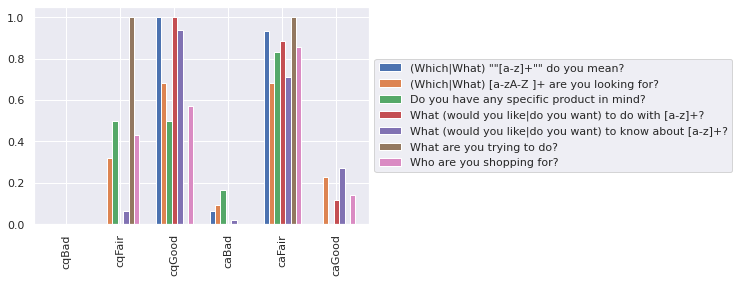

In [ ]:
_normalizer(template_cq_to_count)
copied_template_cq_to_count = count_remover(input_dict=template_cq_to_count)
sorted_template_cq_to_count = collections.OrderedDict(sorted(copied_template_cq_to_count.items()))

pd.DataFrame(sorted_template_cq_to_count).plot(kind='bar', width=0.7)
# Put a legend to the right of the current axis
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(f'{DATASET}_templates_to_count.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
# sorted_template_cq_to_count

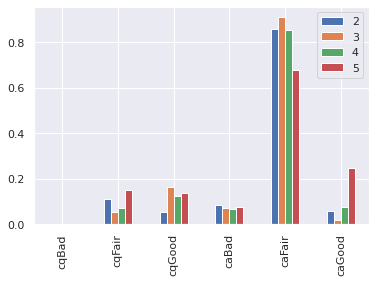

In [ ]:
_normalizer(answers_count_to_labels)
copied_answers_count_to_labels = count_remover(input_dict=answers_count_to_labels)
sorted_answers_count_to_labels = collections.OrderedDict(sorted(copied_answers_count_to_labels.items()))

pd.DataFrame(sorted_answers_count_to_labels).plot(kind='bar')
# Put a legend to the right of the current axis
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(f'{DATASET}_answers_count_to_labels.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
# sorted_answers_count_to_labels

In [ ]:
_normalizer(query_len_to_labels)
copied_query_len_to_labels = count_remover(input_dict=query_len_to_labels)
sorted_query_len_to_labels = collections.OrderedDict(sorted(copied_query_len_to_labels.items()))

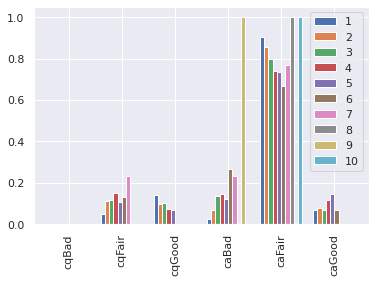

In [ ]:
pd.DataFrame(sorted_query_len_to_labels).plot(kind='bar', width=0.8)
# Put a legend to the right of the current axis
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(f'{DATASET}_query_len_to_labels.pdf', bbox_inches='tight', pad_inches=0)

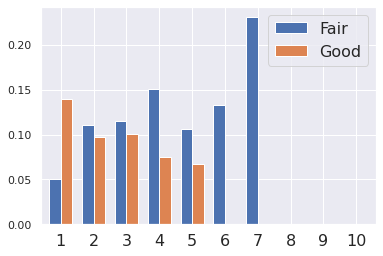

In [ ]:
sorted_query_len_to_labels_df = pd.DataFrame(sorted_query_len_to_labels)
sorted_query_len_to_labels_df.loc[['cqFair', 'cqGood']].T.plot(kind='bar', width=0.7)
plt.legend(labels = ['Fair', 'Good'], prop={'size': 16})
locs, labels = plt.xticks()
plt.xticks(fontsize=16, rotation=0)
# plt.xticks(locs, labels=['Fair', 'Good'], fontsize=16, rotation=0)
plt.savefig(f'{DATASET}_query_len_to_labels.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
# line plot
# pd.DataFrame(sorted_query_len_to_labels).T.plot(kind='line')

In [ ]:
_normalizer(question_len_to_labels)
copied_question_len_to_labels = count_remover(input_dict=question_len_to_labels)
sorted_question_len_to_labels = collections.OrderedDict(sorted(copied_question_len_to_labels.items()))

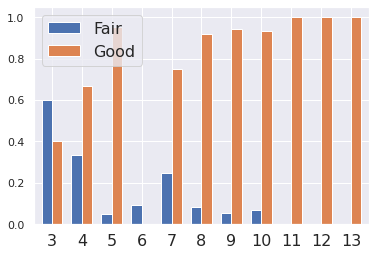

In [ ]:
sorted_question_len_to_labels_df = pd.DataFrame(sorted_question_len_to_labels)
sorted_question_len_to_labels_df.loc[['cqFair', 'cqGood']].T.plot(kind='bar', width=0.7)
plt.legend(labels = ['Fair', 'Good'], prop={'size': 16})
locs, labels = plt.xticks()
plt.xticks(fontsize=16, rotation=0)
# plt.xticks(locs, labels=['Fair', 'Good'], fontsize=16, rotation=0)
plt.savefig(f'{DATASET}_question_len_to_labels.pdf', bbox_inches='tight', pad_inches=0)

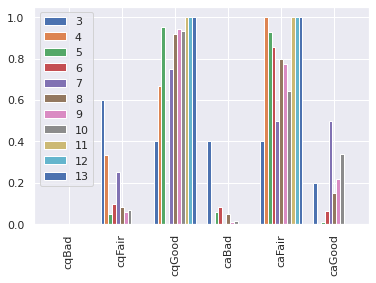

In [ ]:
pd.DataFrame(sorted_question_len_to_labels).plot(kind='bar', width=0.8)
# Put a legend to the right of the current axis
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(f'{DATASET}_question_len_to_labels.pdf', bbox_inches='tight', pad_inches=0)

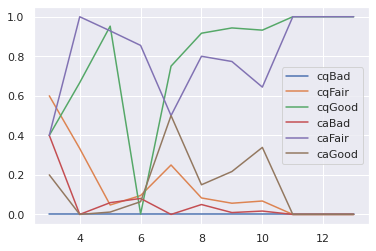

In [ ]:
# line plot
pd.DataFrame(sorted_question_len_to_labels).T.plot(kind='line')

### Faceted vs. Ambiguous

In [ ]:
def add_query_model(query_type, cq_label, ca_label):
  query_model[query_type]['count'] += 1
  if not math.isnan(cq_label):
    if cq_label == 0:
      query_model[query_type]['cqBad'] += 1
    elif cq_label == 1:
      query_model[query_type]['cqFair'] += 1
    elif cq_label == 2:
      query_model[query_type]['cqGood'] += 1
  if not math.isnan(ca_label):
      if ca_label == 0:
        query_model[query_type]['caBad'] += 1
      elif ca_label == 1:
        query_model[query_type]['caFair'] += 1
      elif ca_label == 2:
        query_model[query_type]['caGood'] += 1

In [ ]:
# analysis of generated CQs for faceted and non-faceted query
query_model = dict()
query_model['faceted'] = {'count': 0, 'cqBad': 0, 'cqFair': 0, 'cqGood': 0, 'caBad': 0, 'caFair': 0, 'caGood': 0}
query_model['ambiguous'] = {'count': 0, 'cqBad': 0, 'cqFair': 0, 'cqGood': 0, 'caBad': 0, 'caFair': 0, 'caGood': 0}

for eachline in dataset_df.itertuples(index=True):
  # Faceted query
  # T2: (Which | What) _____ do you mean?
  if bool(re.match(r'(Which|What) ""[a-z]+"" do you mean?', eachline.question)):
    add_query_model('ambiguous', eachline.question_label, eachline.options_overall_label)
  # Non-faceted Query
  else:
    add_query_model('faceted', eachline.question_label, eachline.options_overall_label)

In [ ]:
_normalizer(query_model)
copied_query_model = count_remover(query_model)
sorted_query_model = collections.OrderedDict(sorted(copied_query_model.items()))

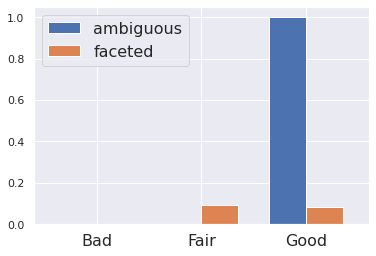

In [ ]:
sorted_query_model_df = pd.DataFrame(sorted_query_model)
sorted_query_model_df.loc[['cqBad', 'cqFair', 'cqGood']].plot(kind='bar', width=0.7)
plt.legend(prop={'size': 16})
locs, labels = plt.xticks()
plt.xticks(locs, labels=['Bad', 'Fair', 'Good'], fontsize=16, rotation=0)
plt.savefig(f'{DATASET}_query_model_to_labels.pdf', bbox_inches='tight', pad_inches=0)

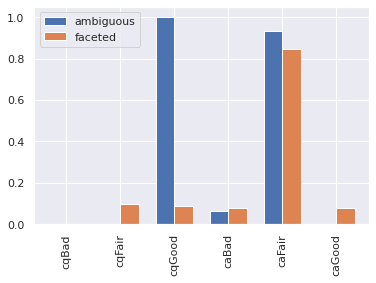

In [ ]:


# pd.DataFrame(sorted_query_model).plot(kind='bar', width=0.7)
# # Put a legend to the right of the current axis
# # plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.savefig(f'{DATASET}_query_model_label.pdf', bbox_inches='tight', pad_inches=0)

### Rouge

In [ ]:
# Should we include the "select to refine the query" clarification questions in this analysis?
# most of them are zero

rouge = Rouge()

rouge1_fmeasure, rouge1_precision, rouge1_recall = [], [], []
rouge2_fmeasure, rouge2_precision, rouge2_recall = [], [], []
rougeL_fmeasure, rougeL_precision, rougeL_recall = [], [], []

nonnan_dataset_df = dataset_df[~dataset_df['question_label'].isna()]

for eachline in tqdm(nonnan_dataset_df.itertuples(index=True)):
  preds = eachline.query
  target = eachline.question
  eval = rouge.get_scores(preds, target)

  rouge1_fmeasure.append(eval[0]['rouge-1']['f'])
  rouge1_precision.append(eval[0]['rouge-1']['p'])
  rouge1_recall.append(eval[0]['rouge-1']['r'])

  rouge2_fmeasure.append(eval[0]['rouge-2']['f'])
  rouge2_precision.append(eval[0]['rouge-2']['p'])
  rouge2_recall.append(eval[0]['rouge-2']['r'])

  rougeL_fmeasure.append(eval[0]['rouge-l']['f'])
  rougeL_precision.append(eval[0]['rouge-l']['p'])
  rougeL_recall.append(eval[0]['rouge-l']['r'])

575it [00:00, 1297.14it/s]


In [ ]:
print("Rouge-1 (F1, Pre, Rec):", round(np.mean(rouge1_fmeasure), 4), round(np.mean(rouge1_precision), 4), round(np.mean(rouge1_recall), 4))
print("Rouge-2 (F1, Pre, Rec):", round(np.mean(rouge2_fmeasure), 4), round(np.mean(rouge2_precision), 4), round(np.mean(rouge2_recall), 4))
print("Rouge-L (F1, Pre, Rec):", round(np.mean(rougeL_fmeasure), 4), round(np.mean(rougeL_precision), 4), round(np.mean(rougeL_recall), 4))

Rouge-1 (F1, Pre, Rec): 0.0408 0.0901 0.027
Rouge-2 (F1, Pre, Rec): 0.0129 0.0328 0.0081
Rouge-L (F1, Pre, Rec): 0.0408 0.0901 0.027


The correlation between the rouge scores and the clarification usefulness scores

In [ ]:
import numpy as np
from scipy import stats
for rouge_metric in [rouge1_fmeasure, rouge1_precision, rouge1_recall, rouge2_fmeasure, rouge2_precision, rouge2_recall, rougeL_fmeasure, rougeL_precision, rougeL_recall]:
  res = stats.pearsonr(rouge_metric, dataset_df.question_label[~dataset_df.question_label.isna()])
  print(res)

(0.3305695654327875, 3.9704337281077464e-16)
(0.3626806639806858, 2.573432182428273e-19)
(0.30757905102364885, 4.590886507739612e-14)
(0.22382883369484785, 5.8110851244321464e-08)
(0.23116886571184406, 2.055101810661361e-08)
(0.22087931664922716, 8.737001664065087e-08)
(0.3305695654327875, 3.9704337281077464e-16)
(0.3626806639806858, 2.573432182428273e-19)
(0.30757905102364885, 4.590886507739612e-14)


In [ ]:
rouge_precision_corr = stats.pearsonr(rouge1_precision, dataset_df.question_label[~dataset_df.question_label.isna()])[0]
rouge_recall_corr = stats.pearsonr(rouge1_recall, dataset_df.question_label[~dataset_df.question_label.isna()])[0]

### Speciteller

In [ ]:
!pip install -U liblinear-official

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 KB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for liblinear-official: filename=liblinear_official-2.46.1-cp38-cp38-linux_x86_64.whl size=146570 sha256=b13fe3f533ebcfc2b06746b30ed0a294b0d10652b3cf71badfa03327c41ee157
  Stored in directory: /root/.cache/pip/wheels/d8/81/b1/c41e218ccdbb56d943dfff43f4ad2071a679ecb2f93c904b49
Successfully built liblinear-official


In [ ]:
! git clone https://github.com/rahmanidashti/CQSatisfaction.git

Cloning into 'CQSatisfaction'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 69 (delta 21), reused 56 (delta 11), pack-reused 0
Unpacking objects: 100% (69/69), 6.58 MiB | 4.90 MiB/s, done.


In [ ]:
cd CQSatisfaction/speciteller

/content/CQSatisfaction/speciteller/CQSatisfaction/speciteller


In [ ]:
# creating query and clarification question file
queries = open('queries', 'w')
cqs = open('cqs', 'w')

for eachline in tqdm(dataset_df.itertuples(index=True)):
  queries.write(eachline.query + "\n")
  cqs.write(eachline.question + "\n")

queries.close()
cqs.close()

2832it [00:00, 255997.18it/s]


In [ ]:
! python speciteller.py --inputfile queries --outputfile queries.probs

loading brown clusters...
done; # words:  247339
loading word embeddings...
done; # words:  268810
SPECITELLER: please make sure that your input sentences are WORD-TOKENIZED for better prediction.
Output to queries.probs done.


In [ ]:
! python speciteller.py --inputfile cqs --outputfile cqs.probs

loading brown clusters...
done; # words:  247339
loading word embeddings...
done; # words:  268810
SPECITELLER: please make sure that your input sentences are WORD-TOKENIZED for better prediction.
Output to cqs.probs done.


In [ ]:
queries_prob = pd.read_csv("queries.probs", names=['prob'])
cqs_prob = pd.read_csv("cqs.probs", names=['prob'])
# adding cqs_prob to the queries_prob dataframe
queries_prob['cqs_prob'] = cqs_prob['prob']
print(queries_prob.shape)

(2832, 2)


In [ ]:
# Remove rows
# queries_prob = queries_prob[queries_prob.cqs_prob <= 0.05]
# print(queries_prob.shape)

In [ ]:
from scipy import stats
specifity_corr = stats.pearsonr(queries_prob['prob'], cqs_prob['prob'])[0]

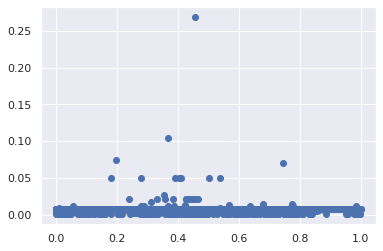

In [ ]:
# plotting the data
plt.scatter(queries_prob['prob'], queries_prob['cqs_prob'])
# This will fit the best line into the graph
# plt.plot(np.unique(queries_prob['prob']), np.poly1d(np.polyfit(queries_prob['prob'], queries_prob['cqs_prob'], 1))(np.unique(queries_prob['prob'])), color='red')

### Query refinement

In [ ]:
#
def query_refinem(query_type, query, cq_label, ca_label):

  q_len = len(query.split(' '))

  query_refinement[query_type]['count'] += 1
  query_refinement[query_type]['sum_len'] += q_len
  if not math.isnan(cq_label):
    if cq_label == 0:
      query_refinement[query_type]['cqBad'] += 1
    elif cq_label == 1:
      query_refinement[query_type]['cqFair'] += 1
    elif cq_label == 2:
      query_refinement[query_type]['cqGood'] += 1
  #
  if not math.isnan(ca_label):
      if ca_label == 0:
        query_refinement[query_type]['caBad'] += 1
      elif ca_label == 1:
        query_refinement[query_type]['caFair'] += 1
      elif ca_label == 2:
        query_refinement[query_type]['caGood'] += 1

In [ ]:
query_refinement = dict()
query_refinement['refine'] = {'count': 0, 'sum_len': 0, 'cqBad': 0, 'cqFair': 0, 'cqGood': 0, 'caBad': 0, 'caFair': 0, 'caGood': 0}
query_refinement['non-refine'] = {'count': 0, 'sum_len': 0, 'cqBad': 0, 'cqFair': 0, 'cqGood': 0, 'caBad': 0, 'caFair': 0, 'caGood': 0}

for eachline in dataset_df.itertuples(index=True):
  if bool(re.match(r'Select one to refine your search', eachline.question)):
    query_refinem('refine', eachline.query, eachline.question_label, eachline.options_overall_label)
  else:
    query_refinem('non-refine', eachline.query, eachline.question_label, eachline.options_overall_label)

In [ ]:
print("> refine - count", query_refinement['refine']['count'])
print("> non-refine - count", query_refinement['non-refine']['count'])
print("")

for attribute in ['sum_len', 'cqBad', 'cqFair', 'cqGood', 'caBad', 'caFair', 'caGood']:
  print(f"> refine - count/{attribute}:", round(query_refinement['refine'][attribute] / query_refinement['refine']['count'], 4))
  print(f"> non-refine - count/{attribute}:", round(query_refinement['non-refine'][attribute] / query_refinement['non-refine']['count'], 4))
  print("")

> refine - count 2490
> non-refine - count 342

> refine - count/sum_len: 2.1325
> non-refine - count/sum_len: 1.9357

> refine - count/cqBad: 0.0
> non-refine - count/cqBad: 0.0

> refine - count/cqFair: 0.0932
> non-refine - count/cqFair: 0.0906

> refine - count/cqGood: 0.0004
> non-refine - count/cqGood: 0.9094

> refine - count/caBad: 0.0807
> non-refine - count/caBad: 0.038

> refine - count/caFair: 0.855
> non-refine - count/caFair: 0.7953

> refine - count/caGood: 0.0643
> non-refine - count/caGood: 0.1667



### Query Classifier

In [ ]:
%%bash

pip install --upgrade pip
pip install git+https://github.com/deepset-ai/haystack.git#egg=farm-haystack[colab]

# Install these to allow pipeline visualization
apt install libgraphviz-dev
pip install pygraphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.8 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 22.0.4
    Uninstalling pip-22.0.4:
      Successfully uninstalled pip-22.0.4
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/deepset-ai/haystack.git to /tmp/pip-install-dh_lonl6/farm-haystack_9697fe58d69442519efe1989bd39224c
  Resolved https://github.com/deepset-ai/haystack.git to commit bde01cbf1f18660f2780c181919bc54aa3c90c58
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ━━━━━━━━━━━

DEPRECATION: git+https://github.com/deepset-ai/haystack.git#egg=farm-haystack[colab] contains an egg fragment with a non-PEP 508 name pip 25.0 will enforce this behaviour change. A possible replacement is to use the req @ url syntax, and remove the egg fragment. Discussion can be found at https://github.com/pypa/pip/issues/11617
  Running command git clone --filter=blob:none --quiet https://github.com/deepset-ai/haystack.git /tmp/pip-install-dh_lonl6/farm-haystack_9697fe58d69442519efe1989bd39224c




In [ ]:
import logging

logging.basicConfig(format="%(levelname)s - %(name)s -  %(message)s", level=logging.WARNING)
logging.getLogger("haystack").setLevel(logging.INFO)

In [ ]:
# Here we create the keyword vs question/statement query classifier
from haystack.nodes import SklearnQueryClassifier
keyword_classifier = SklearnQueryClassifier()

INFO:haystack.telemetry:Haystack sends anonymous usage data to understand the actual usage and steer dev efforts towards features that are most meaningful to users. You can opt-out at anytime by calling disable_telemetry() or by manually setting the environment variable  HAYSTACK_TELEMETRY_ENABLED as described for different operating systems on the documentation page. More information at https://docs.haystack.deepset.ai/docs/telemetry
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DummyClassifier from version 1.2.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.2.0 when using version 1.0.2. This m

In [ ]:
# Here we create the question vs statement query classifier
model_url = (
    "https://ext-models-haystack.s3.eu-central-1.amazonaws.com/gradboost_query_classifier_statements/model.pickle"
)
vectorizer_url = (
    "https://ext-models-haystack.s3.eu-central-1.amazonaws.com/gradboost_query_classifier_statements/vectorizer.pickle"
)

question_classifier = SklearnQueryClassifier(model_name_or_path=model_url, vectorizer_name_or_path=vectorizer_url)

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DummyClassifier from version 0.24.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.24.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator GradientBoostingClassifier from version 0.24.1 when using version 1.0.2. This might lead to breaking code or invalid r

In [ ]:
def add_query_class(query_type, cq_label, ca_label):

  query_class[query_type]['count'] += 1
  if not math.isnan(cq_label):
    if cq_label == 0:
      query_class[query_type]['cqBad'] += 1
    elif cq_label == 1:
      query_class[query_type]['cqFair'] += 1
    elif cq_label == 2:
      query_class[query_type]['cqGood'] += 1
  #
  if not math.isnan(ca_label):
      if ca_label == 0:
        query_class[query_type]['caBad'] += 1
      elif ca_label == 1:
        query_class[query_type]['caFair'] += 1
      elif ca_label == 2:
        query_class[query_type]['caGood'] += 1

In [ ]:
query_class = dict()
query_class['keyword'] = {'count': 0, 'cqBad': 0, 'cqFair': 0, 'cqGood': 0, 'caBad': 0, 'caFair': 0, 'caGood': 0}
query_class['statement'] = {'count': 0, 'cqBad': 0, 'cqFair': 0, 'cqGood': 0, 'caBad': 0, 'caFair': 0, 'caGood': 0}
query_class['question'] = {'count': 0, 'cqBad': 0, 'cqFair': 0, 'cqGood': 0, 'caBad': 0, 'caFair': 0, 'caGood': 0}

for eachline in dataset_df.itertuples(index=True):
    result = keyword_classifier.run(query=eachline.query)
    if result[1] == "output_1":
      # "Question/Statement"
      result_QC = question_classifier.run(query=eachline.query)
      if result_QC[1] == "output_1":
        add_query_class('question', eachline.question_label, eachline.options_overall_label)
      else:
        add_query_class('statement', eachline.question_label, eachline.options_overall_label)
    else:
      add_query_class('keyword', eachline.question_label, eachline.options_overall_label)

In [ ]:
_normalizer(query_class)
copied_query_class = count_remover(query_class)
sorted_query_class = collections.OrderedDict(sorted(copied_query_class.items()))

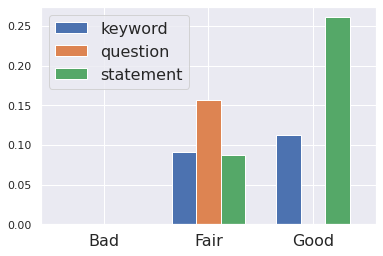

In [ ]:
sorted_query_class_df = pd.DataFrame(sorted_query_class)
sorted_query_class_df.loc[['cqBad', 'cqFair', 'cqGood']].plot(kind='bar', width=0.7)
plt.legend(prop={'size': 16})
locs, labels = plt.xticks()
plt.xticks(locs, labels=['Bad', 'Fair', 'Good'], fontsize=16, rotation=0)
plt.savefig(f'{DATASET}_query_class_to_labels.pdf', bbox_inches='tight', pad_inches=0)

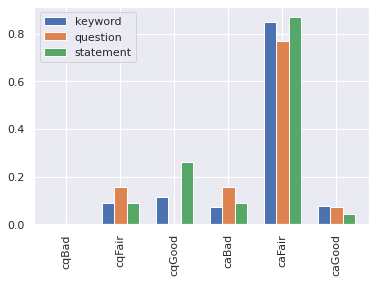

In [ ]:


# pd.DataFrame(sorted_query_class).plot(kind='bar', width=0.7)
# # Put a legend to the right of the current axis
# # plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.savefig(f'{DATASET}_query_class_to_labels.pdf', bbox_inches='tight', pad_inches=0)

### TextBlob Sentiment: Calculating Polarity (Sentiment) and Subjectivity
https://planspace.org/20150607-textblob_sentiment/

In [ ]:
queries_polarity = []
cq_polarity = []

queries_subjectivity = []
cq_subjectivity = []

nonnan_dataset_df = dataset_df[~dataset_df['question_label'].isna()]

for eachline in nonnan_dataset_df.itertuples(index=True):
  queries_polarity.append(TextBlob(eachline.query).sentiment[0])
  cq_polarity.append(TextBlob(eachline.question).sentiment[0])
  queries_subjectivity.append(TextBlob(eachline.query).sentiment[1])
  cq_subjectivity.append(TextBlob(eachline.question).sentiment[1])

In [ ]:
# dataset_df.question_label[~dataset_df.question_label.isna()]
nonnan_dataset_df.question_label

720     1.0
772     2.0
775     2.0
780     2.0
781     2.0
       ... 
2680    2.0
2681    2.0
2682    2.0
2683    2.0
2685    1.0
Name: question_label, Length: 575, dtype: float64

In [ ]:
# subjectivity
res = stats.pearsonr(queries_subjectivity, cq_subjectivity)
print(res)
# res = stats.pearsonr(queries_subjectivity, dataset_df.question_label[~dataset_df.question_label.isna()])
res = stats.pearsonr(queries_subjectivity, nonnan_dataset_df.question_label)
print(res)
res = stats.pearsonr(nonnan_dataset_df.question_label, cq_subjectivity)
print(res)

PearsonRResult(statistic=0.07007045659331715, pvalue=0.09322263147667989)
PearsonRResult(statistic=-0.012323306425308257, pvalue=0.7680926827991115)
PearsonRResult(statistic=0.3741760207626681, pvalue=1.5058036697072992e-20)


In [ ]:
subjectivity_corr = stats.pearsonr(nonnan_dataset_df.question_label, cq_subjectivity)[0]
subjectivity_corr

0.3741760207626681

In [ ]:
# ploarity
res = stats.pearsonr(queries_polarity, cq_subjectivity)
print(res)
res = stats.pearsonr(queries_polarity, nonnan_dataset_df.question_label)
print(res)
res = stats.pearsonr(nonnan_dataset_df.question_label, cq_polarity)
print(res)

PearsonRResult(statistic=0.03850251528686946, pvalue=0.35674219545923835)
PearsonRResult(statistic=-0.048278242652514555, pvalue=0.24775215393303582)
PearsonRResult(statistic=-0.28115485187341616, pvalue=6.595164405106558e-12)


In [ ]:
polarity_corr = stats.pearsonr(nonnan_dataset_df.question_label, cq_polarity)[0]
polarity_corr

-0.28115485187341616

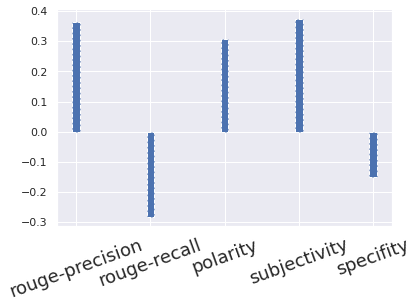

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import numpy as np

metrics = ['rouge-precision', 'rouge-recall', 'polarity', 'subjectivity', 'specifity']
values_1 = [rouge_precision_corr, polarity_corr, rouge_recall_corr, subjectivity_corr, -0.15]

X_axis = np.arange(len(metrics))
  
plt.bar(X_axis, values_1, linestyle='--', width=0.1)

plt.xticks(fontsize=18, rotation=20)
plt.xticks(X_axis, metrics)

plt.savefig('corr_featuers.pdf', bbox_inches='tight')

-0.0024575611466291017

## Feature Extraction

In [ ]:
# clarification question template types via one-hot embeddings (e.g. [0,1,0,0,0]), question length, rouge_precisions, question subjectivity (possibly the sentiment as well)


In [ ]:
feature_data_df = pd.DataFrame(columns=['query', 'cq_vector', 'cq_length', 'rouge_precision', 'cq_polarity', 'cq_subjectivity'])
rouge = Rouge()
for eachline in dataset_df.itertuples(index=True):
  cq = eachline.question
  cq_length = len(eachline.question.split(' '))
  eval = rouge.get_scores(eachline.query, eachline.question)
  rouge_precision = eval[0]['rouge-2']['p']
  cq_subjectivity = TextBlob(eachline.question).sentiment[1]
  cq_polarity = TextBlob(eachline.question).sentiment[0]

  # T0: Select one to refine your search
  if bool(re.match(r'Select one to refine your search', cq)):
    cq_vector = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

  # T1: What (would you like | do you want) to know about _____?
  elif bool(re.match(r'What (would you like|do you want) to know about [a-z]+?', cq)):
    cq_vector = [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]

  # T2: (Which | What) _____ do you mean?
  elif bool(re.match(r'(Which|What) ""[a-z]+"" do you mean?', cq)):
    cq_vector = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

  # T3: (Which | What) _____ are you looking for?
  elif bool(re.match(r'(Which|What) [a-zA-Z ]+ are you looking for?', cq)):
    cq_vector = [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]

  # T4: What (would you like | do you want) to do with _____?
  elif bool(re.match(r'What (would you like|do you want) to do with [a-z]+?', cq)):
    cq_vector = [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]

  # T5: Who are you shopping for?
  elif bool(re.match(r'Who are you shopping for?', cq)):
    cq_vector = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]

  # T6: What are you trying to do?
  elif bool(re.match(r'What are you trying to do?', cq)):
    cq_vector = [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]

  # T7: Do you have _____ in mind?
  elif bool(re.match(r'Do you have [a-z]+ in mind?', cq)):
    cq_vector = [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]

  # T8: Refine your search by interest
  elif bool(re.match(r'Do you have any specific product in mind?', cq)):
    cq_vector = [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]

  # T9: else
  else:
    cq_vector = [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

  feature_data_df = feature_data_df.append({'query': eachline.query, 'cq_vector': cq_vector, 'cq_length': cq_length, 'rouge_precision': rouge_precision, 'cq_polarity': cq_polarity, 'cq_subjectivity': cq_subjectivity}, ignore_index=True)

In [ ]:
feature_data_df.to_csv('feature_data.csv', index=False)

In [ ]:
dataset_meta_info = dataset_df.merge(feature_data_df)

In [ ]:
# This dataset will be used for evaluation of models for prediction with new features
dataset_meta_info.to_csv('MIMICS-Manual-MetaInfo.csv', index=False)

### User Study

In [ ]:
study_dataset_df = dataset_df[~dataset_df['question_label'].isna()]

In [ ]:
sample_study_dataset_df = study_dataset_df.sample(50)

In [ ]:
user_study_df = pd.DataFrame(columns=['Query', 'Clarification Question', 'Option 1', 'Option 2', 'Option 3', 'Option 4', 'Option 5', 'Quesction Label', 'CQ Usefulness', 'Naturalness', 'Grammar', 'Fluency', 'Question Template', 'Coverage', 'Relevance', 'Novelty', 'Efficiency'])

for eachline in sample_study_dataset_df.itertuples(index=True):
  user_study_df = user_study_df.append({'Query': eachline.query, 'Clarification Question': eachline.question, 'Option 1': eachline.option_1,
                                        'Option 2': eachline.option_2, 'Option 3': eachline.option_3, 'Option 4': eachline.option_4,
                                        'Option 5': eachline.option_5, 'Quesction Label': eachline.question_label,
                                        'CQ Usefulness': 0, 'Naturalness': 0, 'Grammar': 0, 'Fluency': 0, 'Question Template': 0,
                                        'Coverage': 0, 'Relevance': 0, 'Novelty': 0, 'Efficiency': 0}, ignore_index=True)



In [ ]:
user_study_df.to_csv("online_user_study.csv", index=False, sep='\t')